# Evaluation Script For Network Related Plots and Values

In [1]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown


import os
import sys

# if current working directory includes "evaluation" change to parent directory
if "evaluation" in os.getcwd():
    os.chdir("..")
    # Add parent directory to sys.path
    sys.path.append(os.getcwd())



# Verify
print(f"Current working directory: {os.getcwd()}")
print(f"sys.path: {sys.path}")

Current working directory: /root/oxn
sys.path: ['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/root/oxn/venv/lib/python3.11/site-packages', '/root/oxn']


# Short Setup Tests

In [2]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation.evaluation as evaluation


importlib.reload(evaluation)

from evaluation.evaluation import Report

assert os.path.exists("reports"), "No reports directory found. Please run the experiments first."

files_in_direcotry = listdir("reports")

# sort them by date
files_in_direcotry.sort(key=lambda x: path.getctime(path.join("reports",x)))

# Load the last experiment
last_experiment = files_in_direcotry[-1]

report_path = path.join("reports", last_experiment.replace(".yaml",".yaml"))
report = Report.from_file(report_path)
print(f"Loaded report {last_experiment}")

assert report is not None, "No report found. Please run the experiments first."
assert isinstance(report, Report), "Report is not of type Report"


assert report.interactions is not None, "No interactions found."
assert report.interactions[0] is not None, "No interactions found. "
assert report.interactions[0].response_data is not None, "No data in interaction found"


Loaded report report_2024-11-18_19-46-28.yaml


In [3]:
# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# cache the dataframes
cached_dataframes_kepler_pods = []
cached_dataframes_kepler_namespace = []

Loading some basic functions used later on

In [4]:

# Function to load a report and extract specific interactions
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None      
        
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    assert interaction.response_data is not None, "No data in interaction found."
                    print(interaction)
                    print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time

def plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time):

        # Normalize t0 and t1 to seconds relative to treatment start time
        treatment_start_seconds = 0  # t0 is always 0 after normalization
        treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

        # Get unique container names
        container_names = combined_df["container_name"].unique()

        # Determine the grid size for subplots
        num_containers = len(container_names)
        num_cols = 2  # Define the number of columns for the grid
        num_rows = ceil(num_containers / num_cols)

        # Create subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
        axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

        # Plot the data for each container_name in a subplot
        for idx, container_name in enumerate(container_names):
            ax = axes[idx]
            assert isinstance(ax, plt.Axes)
            container_df = combined_df[combined_df["container_name"] == container_name]

            for treatment, df in container_df.groupby("treatment"):
                print(df["experiment_seconds"])
                ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

            # Add vertical lines for treatment start and end times (normalized)
            ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
            ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

            ax.set_title(f"Container: {container_name}")
            ax.set_xlabel("Time (seconds from experiment start)")
            ax.set_ylabel(response_name)
            ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
            ax.legend()
            ax.grid()

        # Hide any unused subplots
        for idx in range(num_containers, len(axes)):
            fig.delaxes(axes[idx])

        # Adjust layout
        plt.tight_layout()
        plt.show()
        
def plot_kepler_metrics(combined_df, response_name, treatment_end_time, treatment_start_time, container_namespace):

    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    fig, ax = plt.subplots(figsize=(6, 6))

    

    namespace_df = combined_df[combined_df["container_namespace"] == container_namespace]

    print(namespace_df)

    for treatment, df in namespace_df.groupby("treatment"):
        print(df["experiment_seconds"])
        ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

    # Add vertical lines for treatment start and end times (normalized)
    ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    ax.set_title(f"Namespace: {container_namespace}")
    ax.set_xlabel("Time (seconds from experiment start)")
    ax.set_ylabel(response_name)
    #ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
    ax.legend()
    ax.grid()

    
    # Adjust layout
    plt.tight_layout()
    plt.show()
   

## Network Trafic Energy Consumption

In [5]:
# Directory containing reports
report_directory = "reports/"
treatment_names = ["delay_treatment", "empty_treatment", "increase_otel_metric_interval"]
#                       baseline                            delay 1m                            delay 1s                        5% sampling
report_names = ["report_2024-11-18_17-53-23.yaml", "report_2024-11-18_18-31-01.yaml", "report_2024-11-18_19-08-29.yaml", "report_2024-11-18_19-46-28.yaml"]

response_name = "cadvisor_network_bytes_transmitted_all_absolute"

report_base_network_namespace = load_report_interactions(report_directory, report_names[0], response_name, "empty_treatment")
report_delay_network_namespace = load_report_interactions(report_directory, report_names[1], response_name, "delay_treatment")
report_delay_1s_network_namespace = load_report_interactions(report_directory, report_names[2], response_name, "delay_treatment")
report_sampling_5_percent_network_namespace = load_report_interactions(report_directory, report_names[3], response_name, "empty_treatment")

[Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVari

In [6]:
def get_network_energy_consumption(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["container_label_app_kubernetes_io_name"].unique())
    #print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("container_label_app_kubernetes_io_name"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment"
        treatment_df = df[df[treatment_name] == treatment_name]
    
        
        if not treatment_df.empty:
           # get the first and last value of the treatment
            treatment_start = treatment_df["cadvisor_network_bytes_transmitted_all_absolute"].iloc[0]
            treatment_end = treatment_df["cadvisor_network_bytes_transmitted_all_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")

    return treatment_start_end_values
treatment_start_end = {}

report_base_network_namespace_values = get_network_energy_consumption(report_base_network_namespace, "empty_treatment")
report_delay_network_namespace_values = get_network_energy_consumption(report_delay_network_namespace, "delay_treatment")
report_delay_1s_storage_namespace_values = get_network_energy_consumption(report_delay_1s_network_namespace, "delay_treatment")
report_sampling_5_percent_storage_namespace_values = get_network_energy_consumption(report_sampling_5_percent_network_namespace, "empty_treatment")

for container_namespace, values in report_base_network_namespace_values.items():
    percentage_differece_delay = (report_delay_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
    percentage_differece_delay_1s = (report_delay_1s_storage_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
    percentage_differece_sampling = (report_sampling_5_percent_storage_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
    print(f"Container: {container_namespace}")
    print(f"Base Treatment: {report_base_network_namespace_values[container_namespace][2]}")
    print(f"Delay Treatment: {report_delay_network_namespace_values[container_namespace][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {report_delay_1s_storage_namespace_values[container_namespace][2]} ({percentage_differece_delay_1s:.2f}%)")
    print(f"Sampling 5% Treatment: {report_sampling_5_percent_storage_namespace_values[container_namespace][2]} ({percentage_differece_sampling:.2f}%)")
    
    print("-----------------------------------------------")

Container: astronomy-shop-accountingservice
Base Treatment: 7354729
Delay Treatment: 7438223 (1.14%)
Delay 1s Treatment: 7643060 (3.92%)
Sampling 5% Treatment: 7721724 (4.99%)
-----------------------------------------------
Container: astronomy-shop-adservice
Base Treatment: 13844724
Delay Treatment: 13928825 (0.61%)
Delay 1s Treatment: 13996944 (1.10%)
Sampling 5% Treatment: 15258437 (10.21%)
-----------------------------------------------
Container: astronomy-shop-cartservice
Base Treatment: 111023019
Delay Treatment: 110028989 (-0.90%)
Delay 1s Treatment: 112847194 (1.64%)
Sampling 5% Treatment: 117488136 (5.82%)
-----------------------------------------------
Container: astronomy-shop-checkoutservice
Base Treatment: 57062517
Delay Treatment: 56476873 (-1.03%)
Delay 1s Treatment: 57998185 (1.64%)
Sampling 5% Treatment: 59816056 (4.83%)
-----------------------------------------------
Container: astronomy-shop-currencyservice
Base Treatment: 26010808
Delay Treatment: 25813004 (-0.76%)

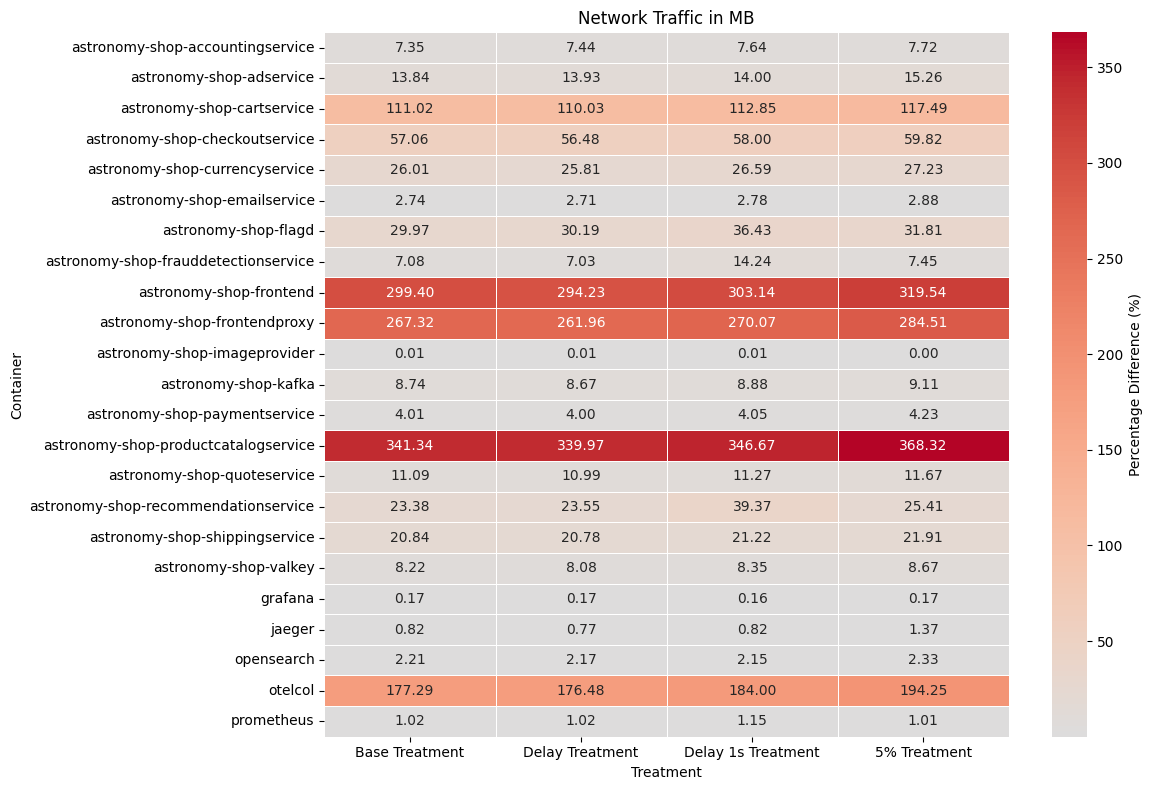

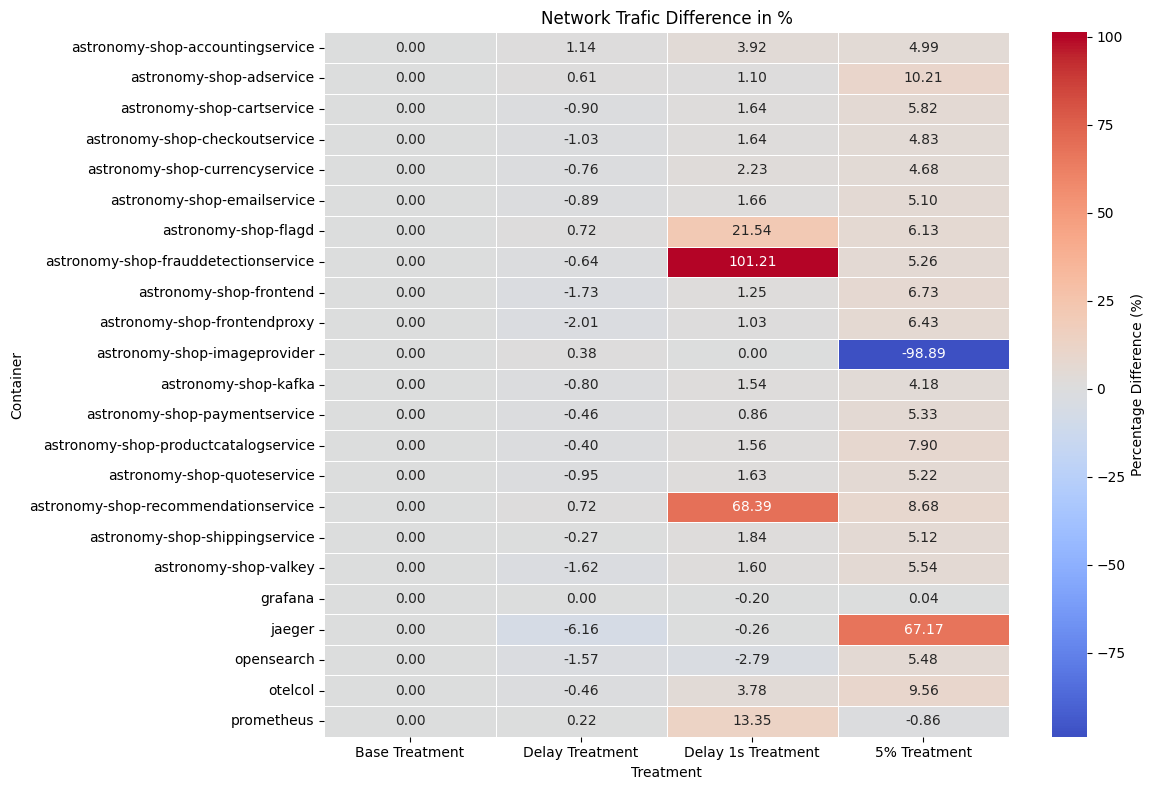

In [7]:
def generate_difference_matrix_percentage(treatment_start_end_base, treatment_start_end_delay, treatment_start_end_delay_1s, treatment_start_end_5percent):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers],
        "Delay Treatment": [treatment_start_end_delay[c][2] for c in containers],
        "Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in ["Base Treatment", "Delay Treatment", "Delay 1s Treatment", "5% Treatment"]:
        percentage_difference[col] = (df[col] - df["Base Treatment"]) / df["Base Treatment"] * 100

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Network Trafic Difference in %")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()
    
def generate_difference_matrix(treatment_start_end_base, treatment_start_end_delay, treatment_start_end_delay_1s, treatment_start_end_5percent):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers],
        "Delay Treatment": [treatment_start_end_delay[c][2] for c in containers],
        "Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # convert byte to megabytes
    percentage_difference = df.copy()
    for col in ["Base Treatment", "Delay Treatment", "Delay 1s Treatment", "5% Treatment"]:
        percentage_difference[col] = df[col] / 1000 / 1000 

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Network Traffic in MB")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()


generate_difference_matrix(
    report_base_network_namespace_values,
    report_delay_network_namespace_values,
    report_delay_1s_storage_namespace_values,
    report_sampling_5_percent_storage_namespace_values
)

generate_difference_matrix_percentage(
    report_base_network_namespace_values,
    report_delay_network_namespace_values,
    report_delay_1s_storage_namespace_values,
    report_sampling_5_percent_storage_namespace_values
)

